# Data Preprocessing - Binning

Data binning (or bucketing) groups data in bins (or buckets), in the sense that it replaces values contained into a small interval with a single representative value for that interval. Sometimes binning improves accuracy in predictive models. 

Data binning is a type of data preprocessing, a mechanism which includes also dealing with [missing values](https://towardsdatascience.com/data-preprocessing-with-python-pandas-part-1-missing-data-45e76b781993), [formatting](https://towardsdatascience.com/data-processing-with-python-pandas-part-2-data-formatting-710c2eafa426), [normalization](https://towardsdatascience.com/data-preprocessing-with-python-pandas-part-3-normalisation-5b5392d27673) and [standardization](https://towardsdatascience.com/data-preprocessing-with-python-pandas-part-4-standardization-ccd5b1608f1c).

Binning can be applied to convert numeric values to categorical or to sample (quantise) numeric values. 
* convert numeric to categorical includes binning by distance and binning by frequency
* reduce numeric values includes quantisation (or sampling).

Binning is a technique for data smoothing. Data smoothing is employed to remove noise from data. Three techniques for data smoothing:
* binning
* regression
* outlier analysis


## Data Import
In this tutorial we exploit the `cupcake.csv` dataset, which contains the trend search of the word `cupcake` on Google Trends. Data are extracted from [this link](https://trends.google.com/trends/explore?q=%2Fm%2F03p1r4&date=all). We exploit the `pandas` library to import the dataset and we transform it into a dataframe through the `read_csv()` function.

In [47]:
import pandas as pd
df = pd.read_csv('cupcake.csv')
df.head(5)

,Mese,Cupcake
0,2004-01,5
1,2004-02,5
2,2004-03,4
3,2004-04,6
4,2004-05,5


## Binning by distance

In this case we define the edges of each bin. We group values related to the column `Cupcake` into three groups: *small*, *medium* and *big*. 
In order to do it, we need to calculate the intervals within each group falls. We calculate the interval range as the difference between the maximum and minimum value and then we split this interval into three parts, one for each group.
We exploit the functions `min()` and `max()` of dataframe to calculate the minimum value and the maximum value of the column `Cupcake`.

In [48]:
min_value = df['Cupcake'].min()
max_value = df['Cupcake'].max()
print(min_value)
print(max_value)

4
100


Now we can calculate the range of each interval, i.e. the minimum and maximum value of each interval. Since we have 3 groups, we need 4 edges of intervals (bins):
* small - (edge1, edge2)
* medium - (edge2, edge3)
* big - (edge3, edge4)

We can use the `linspace()` function of the `numpy` package to calculate the 4 bins, equally distributed.

In [49]:
import numpy as np
bins = np.linspace(min_value,max_value,4)
bins

array([  4.,  36.,  68., 100.])

Now we define the labels:

In [50]:
labels = ['small', 'medium', 'big']

We can use the `cut()` function to convert the numeric values of the column `Cupcake` into the categorical values. We need to specify the bins and the labels. In addition, we set the parameter `include_lowest` to `True` in order to include also the minimum value.

In [51]:
df['bin_cut_linspace'] = pd.cut(df['Cupcake'], bins=bins, labels=labels, include_lowest=True)

We can plot the distribution of values, by using the `hist()` function of the `matplotlib` package.

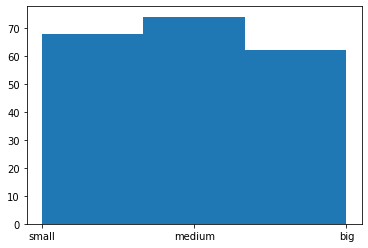

In [52]:
import matplotlib.pyplot as plt

plt.hist(df['bin_cut_linspace'], bins=3)
plt.show()

Alternatively, we can set the edges of each bin manually.

In [53]:
bins = [ 0, 10, 50, 100 ]
df['bin_cut_manual'] = pd.cut(df['Cupcake'] , bins=bins, labels=labels, include_lowest=True)

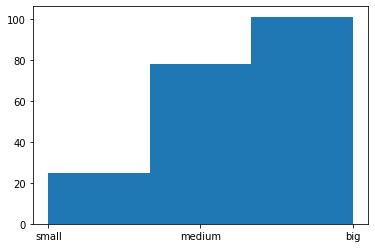

In [54]:
plt.hist(df['bin_cut_manual'], bins=3)
plt.show()

# Binning by frequency
Binning by frequency calculates the size of each bin so that each bin contains the (almost) same number of observations, but the bin range will vary. We can use the Python `pandas` `qcut()` function. We can set the `precision` parameter to define the number of decimal points.

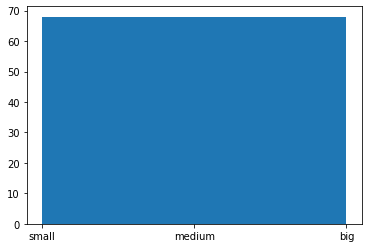

In [59]:
df['bin_qcut'] = pd.qcut(df['Cupcake'], q=3,precision=1, labels=labels)
plt.hist(df['bin_qcut'], bins=3)
plt.show()

Now we can plot how data observations are transformed.

## Sampling
Sampling is another technique of data binning. It permits to reduce the number of samples, by grouping similar values or contiguous values.
There are three approaches to perform sampling:
* by bin means: each value in a bin is replaced by the mean value of the bin.
* by bin median: each bin value is replaced by its bin median value.
* by bin boundary: each bin value is replaced by the closest boundary value, i.e. maximum or minimum value of the bin.

In order to perform sampling, the `binned_statistic()` function of the `scipy.stats` package can be used. This function receives two arrays as input, `x_data` and `y_data`, as well as the statistics to be used (e.g. median or mean) and the number of bins to be created. The function returns the values of the bins as well as the edges of each bin. 

In [124]:
from scipy.stats import binned_statistic
x_data = np.arange(0, len(df))
y_data = df['Cupcake']
y_bins,bin_edges, misc = binned_statistic(x_data,y_data, statistic="mean", bins=10)
bin_edges

Now we should approximate each value of the `df['Cupcake']` column to the median value of the corresponding bin. Thus we convert the bin edges to an `IntervalIndex`, which receives as index the left and right edges of each interval. In our case, the left edges starts from the beginning of the bin edges and do not contain the last value of the bin edges. The right edges instead, start from the second value of the bin edges and last until the last value.

In [126]:
bin_intervals = pd.IntervalIndex.from_arrays(bin_edges[:-1], bin_edges[1:])

We can quantise the `Cupcake` column by defining a `set_to_median()` function which loops through the intervals and when it finds the correct interval, it returns the mid value.

In [127]:
def set_to_median(x, bin_intervals):
    for interval in bin_intervals:
        if x in interval:
            return interval.mid

We use the `apply()` function to apply the `set_to_median()` to the `Cupcake` column.

In [128]:
df['sampled_cupcake'] = df['Cupcake'].apply(lambda x: set_to_median(x, bin_intervals))

Now we can plot results. We note the loss of information.

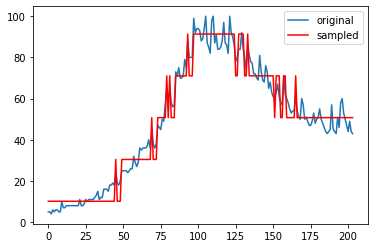

In [129]:
plt.plot(df['Cupcake'], label='original')
plt.plot(df['sampled_cupcake'], color='red', label='sampled')
plt.legend()
plt.show()

Finally, we can plot the median values. We can calculate the `x` values (`x_bins`) corresponding to the binned values (`y_bins`) as the values at the center of the bin range.

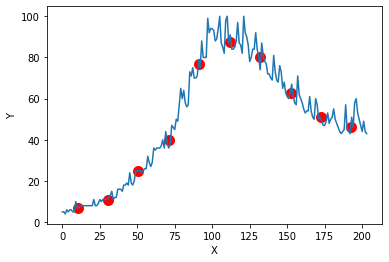

In [8]:
x_bins = (bin_edges[:-1]+bin_edges[1:])/2
plt.plot(x_data,y_data)
plt.xlabel("X"); 
plt.ylabel("Y")

plt.scatter(x_bins, y_bins,  color= 'red',linewidth=5)
plt.show()